历史k线最高与最低价相关系数平方均值

In [1]:
import polars as pl
import numpy as np

# 读取数据
data = pl.read_parquet("hourly_data.pa")

df = data.sort('open_time').sort('symbol')

# 设置窗口大小 N
N = 63

# 创建一个空的列表来存储结果
result_rows = []

# 获取所有的 unique symbols
symbols = df["symbol"].unique()

# 计算相关系数的函数
def rolling_corr(high, low):
    return np.corrcoef(high, low)[0, 1]

# 使用 groupby 进行分组并计算滚动窗口的相关系数
def calculate_rolling_corr(group):
    high_series = group["high"].to_numpy()
    low_series = group["low"].to_numpy()

    rolling_correlations = []
    for i in range(N - 1, len(high_series)):
        high_window = high_series[i - N + 1:i + 1]
        low_window = low_series[i - N + 1:i + 1]
        correlation = rolling_corr(high_window, low_window)
        rolling_correlations.append(correlation**2)

    return pl.DataFrame({
        "open_time": group["open_time"][N - 1:],
        "symbol": group["symbol"][N - 1:],
        "correlation^2": rolling_correlations
    })

# 使用groupby进行分组并应用函数
result_df = df.groupby("symbol").apply(calculate_rolling_corr).sort('open_time').sort('symbol')

# 打印结果
print(result_df)

/var/folders/8p/_lylf4tn2yz39y4qkw9vg1jw0000gn/T/ipykernel_1374/3820473893.py:41: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  result_df = df.groupby("symbol").apply(calculate_rolling_corr).sort('open_time').sort('symbol')
/var/folders/8p/_lylf4tn2yz39y4qkw9vg1jw0000gn/T/ipykernel_1374/3820473893.py:41: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_groups`.
  result_df = df.groupby("symbol").apply(calculate_rolling_corr).sort('open_time').sort('symbol')


shape: (2_474_072, 3)
┌─────────────────────┬──────────────┬───────────────┐
│ open_time           ┆ symbol       ┆ correlation^2 │
│ ---                 ┆ ---          ┆ ---           │
│ datetime[μs]        ┆ str          ┆ f64           │
╞═════════════════════╪══════════════╪═══════════════╡
│ 2022-09-12 03:00:00 ┆ 1000LUNCUSDT ┆ 0.322448      │
│ 2022-09-12 04:00:00 ┆ 1000LUNCUSDT ┆ 0.583507      │
│ 2022-09-12 05:00:00 ┆ 1000LUNCUSDT ┆ 0.593554      │
│ 2022-09-12 06:00:00 ┆ 1000LUNCUSDT ┆ 0.588438      │
│ 2022-09-12 07:00:00 ┆ 1000LUNCUSDT ┆ 0.608425      │
│ …                   ┆ …            ┆ …             │
│ 2022-12-31 19:00:00 ┆ ZRXUSDT      ┆ 0.947164      │
│ 2022-12-31 20:00:00 ┆ ZRXUSDT      ┆ 0.944501      │
│ 2022-12-31 21:00:00 ┆ ZRXUSDT      ┆ 0.943012      │
│ 2022-12-31 22:00:00 ┆ ZRXUSDT      ┆ 0.941415      │
│ 2022-12-31 23:00:00 ┆ ZRXUSDT      ┆ 0.939868      │
└─────────────────────┴──────────────┴───────────────┘


In [2]:
# # 计算相关系数的滚动均值并加入原始结果中
result_df = result_df.with_columns([
    pl.col("correlation^2").rolling_mean(N).alias("mean_corr^2")
])

factors = result_df.select(['open_time', 'symbol', 'mean_corr^2'])
factors.sort('open_time').sort('symbol')

open_time,symbol,mean_corr^2
datetime[μs],str,f64
2022-09-12 03:00:00,"""1000LUNCUSDT""",null
2022-09-12 04:00:00,"""1000LUNCUSDT""",null
2022-09-12 05:00:00,"""1000LUNCUSDT""",null
2022-09-12 06:00:00,"""1000LUNCUSDT""",null
2022-09-12 07:00:00,"""1000LUNCUSDT""",null
…,…,…
2022-12-31 19:00:00,"""ZRXUSDT""",0.942233
2022-12-31 20:00:00,"""ZRXUSDT""",0.941927
2022-12-31 21:00:00,"""ZRXUSDT""",0.941611


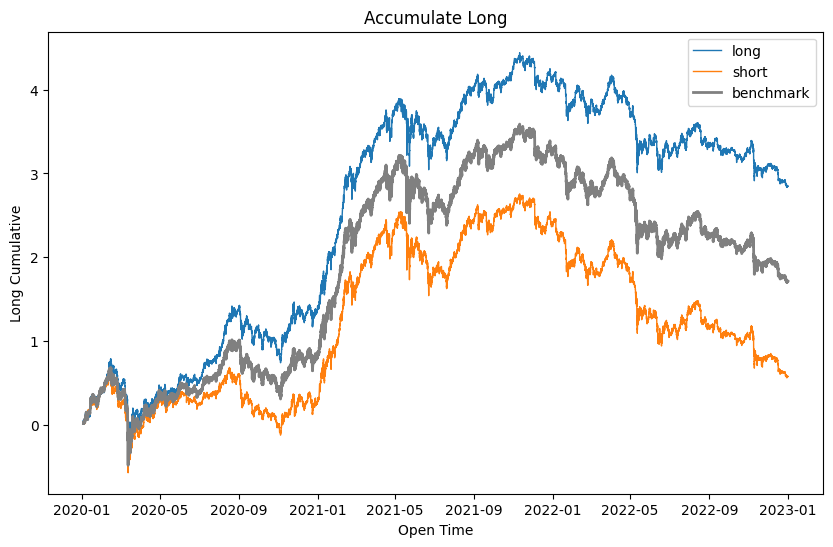

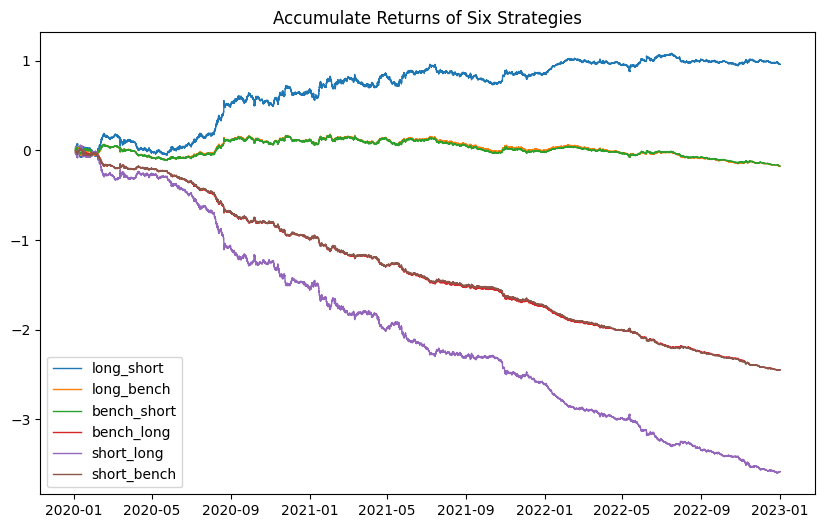

long: 
ann_return = 0.9499  sharpe = 0.8477  maxdd = 0.6616  calmar_ratio = 1.4357  

short: 
ann_return = 0.1914  sharpe = 0.179  maxdd = 0.7322  calmar_ratio = 0.2614  

bench: 
ann_return = 0.5707  sharpe = 0.5255  maxdd = 0.6947  calmar_ratio = 0.8215  

long_short: 
ann_return = 0.3205  sharpe = 1.1387  maxdd = 0.2027  calmar_ratio = 1.5809  

long_bench: 
ann_return = -0.0588  sharpe = -0.4152  maxdd = 0.3022  calmar_ratio = -0.1947  

bench_long: 
ann_return = -0.8172  sharpe = -5.7674  maxdd = 2.4103  calmar_ratio = -0.339  

short_long: 
ann_return = -1.1965  sharpe = -4.2511  maxdd = 3.4577  calmar_ratio = -0.346  

short_bench: 
ann_return = -0.8173  sharpe = -5.7919  maxdd = 2.4225  calmar_ratio = -0.3374  

bench_short: 
ann_return = -0.0587  sharpe = -0.4159  maxdd = 0.2973  calmar_ratio = -0.1974  



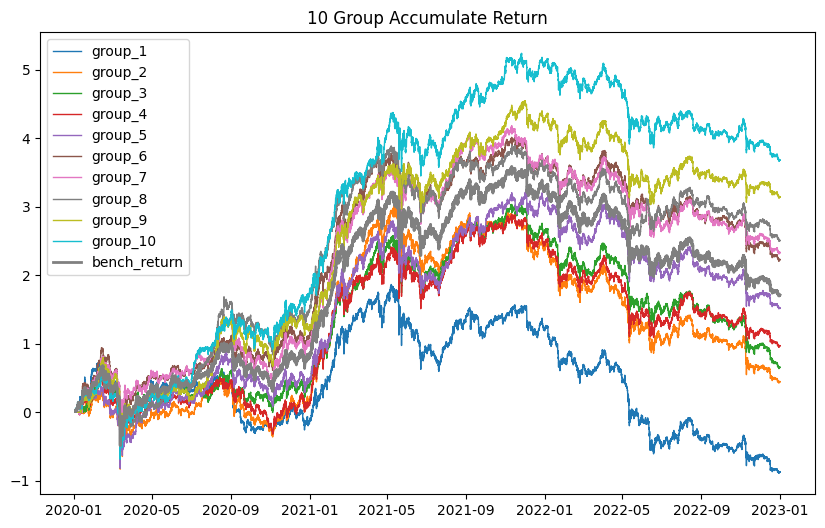

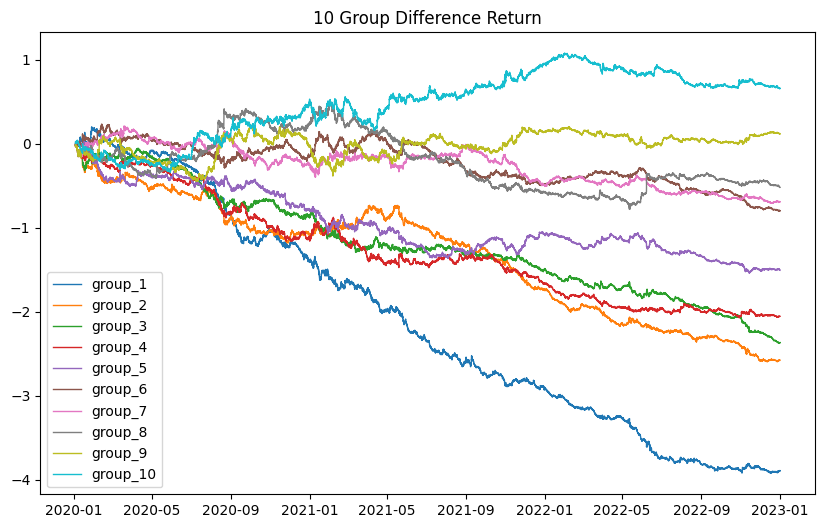

group_1: 
ann_return = -0.2905  sharpe = -0.2697  maxdd = 0.9618  calmar_ratio = -0.302  

group_2: 
ann_return = 0.1488  sharpe = 0.1352  maxdd = 0.8718  calmar_ratio = 0.1707  

group_3: 
ann_return = 0.2185  sharpe = 0.1963  maxdd = 0.7073  calmar_ratio = 0.3088  

group_4: 
ann_return = 0.3235  sharpe = 0.2876  maxdd = 0.7982  calmar_ratio = 0.4053  

group_5: 
ann_return = 0.5061  sharpe = 0.4455  maxdd = 0.8685  calmar_ratio = 0.5828  

group_6: 
ann_return = 0.7423  sharpe = 0.6478  maxdd = 0.6835  calmar_ratio = 1.086  

group_7: 
ann_return = 0.7775  sharpe = 0.6778  maxdd = 0.6035  calmar_ratio = 1.2884  

group_8: 
ann_return = 0.8358  sharpe = 0.7167  maxdd = 0.6823  calmar_ratio = 1.2249  

group_9: 
ann_return = 1.0482  sharpe = 0.8968  maxdd = 0.6555  calmar_ratio = 1.5991  

group_10: 
ann_return = 1.2292  sharpe = 1.019  maxdd = 0.8054  calmar_ratio = 1.5263  

-----------------------------------------
group_difference_1: 
ann_return = -1.2991  sharpe = -3.6494  maxdd 

In [3]:
from factor_analysis.factor_analysis import FactorAnalysis

# 假设 result_df 和 data 已经被读取
analysis = FactorAnalysis(factors, df)
analysis.run_full_analysis()